## Load data

In [299]:
import load_data
import os
import pandas as pd
import numpy as np
import sklearn.linear_model
import sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns
import plot
import time
import datetime
import numpy as np

allDf = load_data.getPandasDataframes()

bejAirDf = allDf[('Beijing', 'air')]
bejMetDf = allDf[('Beijing', 'met')]
bejGrd = allDf[('Beijing', 'grid')]

bejAirDf['newTime'] = pd.to_datetime(bejAirDf['time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
bejMetDf['time'] = pd.to_datetime(bejMetDf['time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
bejGrd['time'] = pd.to_datetime(bejGrd['time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

bejMetDf = bejMetDf.rename(columns={'station_id':'met_station'})
bejGrd = bejGrd.rename(columns={'station_id':'met_station'})

bejDf = pd.DataFrame()
for key in ['station_id', 'PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration', 'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']:
    bejDf[key] = bejAirDf[key]
bejDf['time'] = bejAirDf['newTime']

bejDf['hour'] = bejAirDf['newTime'].dt.hour
#bejDf['minute'] = bejAirDf['newTime'].dt.minute
#bejDf['second'] = bejAirDf['newTime'].dt.second
bejDf['day'] = bejAirDf['newTime'].dt.day
bejDf['month'] = bejAirDf['newTime'].dt.month
#bejDf['year'] = bejAirDf['newTime'].dt.year
bejDf['dayofweek'] = bejAirDf['newTime'].dt.dayofweek
bejDf['dayofweek'] = pd.Categorical(bejDf['dayofweek'], ordered=False)

valueDict = {(row['station_id'],row['time'].to_pydatetime()):row['PM10_Concentration'] for index, row in bejDf.iterrows()}
bejDf['PM10_3'] = bejDf['PM10_Concentration']
bejDf['PM10_3B'] = bejDf['PM10_Concentration']
bejDf['PM10_3C'] = bejDf['PM10_Concentration']
for index, row in bejDf.iterrows():
    rtime = row['time'].to_pydatetime()
    rtime = rtime - datetime.timedelta(hours=1)
    rtime2 = rtime - datetime.timedelta(hours=1)
    rtime3 = rtime2 - datetime.timedelta(hours=1)
    bejDf.at[index, 'PM10_3'] = valueDict.get((row['station_id'], rtime), np.NaN)
    bejDf.at[index, 'PM10_3B'] = valueDict.get((row['station_id'], rtime2), np.NaN)
    bejDf.at[index, 'PM10_3C'] = valueDict.get((row['station_id'], rtime3), np.NaN)


#stationDf = bejDf[bejDf['station_id']=='tiantan_aq']
#ToDo: limit to one station for now
#bejDf = stationDf

if False:
    plt.scatter(x=bejDf.PM25_Concentration, y=bejDf.PM10_Concentration)
    plt.xlabel("time", fontsize=14)
    plt.ylabel("PM10_Concentration", fontsize=14)
    f = plt.gcf()
    f.set_figheight(10)
    f.set_figwidth(15)
    plt.show()
    
bejDf['businessHours'] = 0
bejDf.loc[(bejDf['hour'] >= 8) & (bejDf['hour']<=18)==0, 'businessHours'] = 1

# bejDf = bejDf.fillna(bejDf.median())
# bejDf = pd.get_dummies(bejDf, 'dum')


https://biendata.com/competition/airquality/bj/2017-01-01-0/2018-05-31-23/2k0d1d8
data/Beijing/air/bj_airquality_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/bj/2017-01-01-0/2018-05-31-23/2k0d1d8
data/Beijing/met/bj_meteorology_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/bj_grid/2017-01-01-0/2018-05-31-23/2k0d1d8
data/Beijing/grid/bj_grid_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/airquality/ld/2017-01-01-0/2018-05-31-23/2k0d1d8
data/London/air/ld_airquality_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/ld/2017-01-01-0/2018-05-31-23/2k0d1d8
data/London/met/ld_meteorology_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/ld_grid/2017-01-01-0/2018-05-31-23/2k0d1d8
data/London/grid/ld_grid_2017-01-01-0_2018-05-31-23.csv



## Load spatial data

In [332]:
bj1718meo = pd.read_csv('viz/stash/beijing_17_18_meo.csv')
bj1718meo = bj1718meo.rename(columns={'station_id':'met_station'})
bj_meo_stations = pd.read_csv('viz/stash/Beijing_meo_stations.csv')
bj_grid_stations = pd.read_csv('viz/stash/beijing_grid_stations.csv', names=['met_station', 'latitude', 'longitude'])
bj_ring = pd.read_csv('viz/stash/Beijing_Neighbors.csv')
bj_nn = pd.read_excel('viz/stash/Beijing_Neighbors.xlsx')
bj_nn = bj_nn.rename(columns={"aq_station": "station_id"})

In [333]:
bj_nn[bj_nn['met_station']=='fangshan_met'] =  'fangshan_meo'

## Join data

In [334]:
temp = bejDf.merge(bj_nn, on='station_id', how='left')
bejWeather = pd.concat([bejMetDf, bejGrd])
temp = pd.merge(temp, bejWeather,  how='left', on=['met_station','time'])
temp = temp.drop(columns='id')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [335]:
temp['weather'].replace('Cloudy','CLOUDY', inplace=True)
temp['weather'].replace('Sunny/clear','CLEAR_DAY', inplace=True)
temp['weather'].replace('Rain','RAIN', inplace=True)

##  Correlation Plot on Numeric Columns

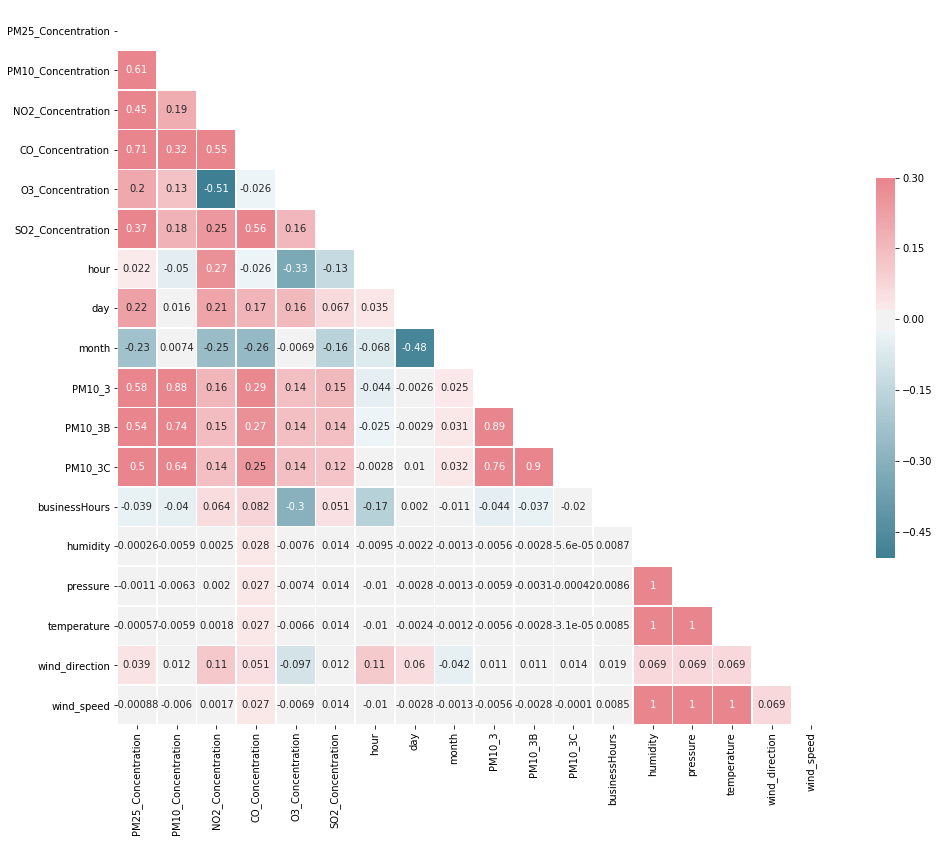

In [336]:
tempNum = temp.select_dtypes('number')
tempNum = tempNum.dropna()
tempCor = tempNum.corr()
mask = np.zeros_like(tempCor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(tempCor, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [337]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

In [338]:
temp.loc[temp['humidity']== 999999, 'humidity'] = temp['humidity'].median()
temp.loc[temp['pressure']== 999999, 'pressure'] = temp['pressure'].median()
temp.loc[temp['temperature']== 999999, 'temperature'] = temp['temperature'].median()

# temp[temp['humidity']== 999999]

## Aggregate data by time for time plot

In [339]:
agg = temp.groupby('time', as_index=False).median()

In [340]:
trace0 = go.Scatter(
    x = agg.time,
    y = agg.PM10_Concentration,
    mode = 'lines',
    name = 'PM10_Concentration',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 1)
)
trace1 = go.Scatter(
    x = agg.time,
    y = agg.PM25_Concentration,
    mode = 'lines',
    name = 'PM25_Concentration',
    line = dict(
        color = ('rgb(253, 153, 255)'),
        width = 1)
)
trace2 = go.Scatter(
    x = agg.time,
    y = agg.O3_Concentration,
    mode = 'lines',
    name = 'O3_Concentration',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 1)
)
trace3 = go.Scatter(
    x = agg.time,
    y = agg.humidity,
    mode = 'lines',
    name = 'Humidity',
    line = dict(
        color = ('rgb(0, 250, 0)'),
        width = 1)
)
trace4 = go.Scatter(
    x = agg.time,
    y = agg.temperature,
    mode = 'lines',
    name = 'Temperature',
    line = dict(
        color = ('rgb(255,215,0)'),
        width = 1)
)
trace5 = go.Scatter(
    x = agg.time,
    y = agg.pressure,
    mode = 'lines',
    name = 'Pressure',
    line = dict(
        color = ('rgb(255,215,0)'),
        width = 1)
)
data = [trace0,trace1,trace2,trace3,trace4,trace5]
layout = dict(
    title='Mean Air Quality and Temp/Humidity by Day',
    xaxis=dict(
        rangeslider=dict(),
        type='date'
    )
)
fig = dict(data=data, layout=layout)

py.offline.iplot(fig)


In [341]:
bj_grid_met_stations = pd.concat([bj_grid_stations, bj_meo_stations.rename(columns={'station_id':'met_station'})], ignore_index=True)
temp = pd.merge(temp, bj_grid_met_stations, how='left', on = 'met_station')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


## Summary of Columns

'station_id' - station ID for Air Quality Station

'PM25_Concentration' - PM 2.5 Concentration

'PM10_Concentration' - PM 10 Concentration

'NO2_Concentration' - NO2 Concentration

'CO_Concentration' - CO Concentration

'O3_Concentration' - O3 Concentration

'SO2_Concentration' - SO2 Concentration

'time' - date and time

'hour' - hour of day

'day' - day in format '02'

'month' - month in formate '02'

'dayofweek' - day of week, from 0 to 6, where Monday is 0

'PM10_3' - 

'PM10_3B' - 

'PM10_3C'

'businessHours' - binary, 1 is during business hours (between 8am and 6pm)

'met_station' - nearest station with observed weather data

'humidity' - humidity

'pressure' - air pressure

'temperature' - temperature in celcius

'weather' - categorical weather information (cloudy? rain? snow? etc.)

'wind_direction' - direction wind is blowing

'wind_speed' - wind speed

'latitude' - latitude of met_station

'longitude' - longitude of met_station

In [293]:
# agg_loc = temp.groupby('station_id', as_index=False).median()
# temp_no_na = temp.dropna()

In [330]:
# import folium
# m = folium.Map(location=[30,110], tiles="Mapbox Bright", zoom_start=4)

# for i in range(0,len(temp_no_na)):
#    folium.Circle(
#       location=[temp_no_na.iloc[i]['longitude'], temp_no_na.iloc[i]['latitude']],
#       radius=temp_no_na.iloc[i]['O3_Concentration']*10000,
#       color='crimson',
#       fill=True,
#       fill_color='crimson'
#    ).add_to(m)


# display(m)

In [542]:
# ct = datetime.datetime.utcnow() - datetime.timedelta(days=2)
# splitDate = pd.datetime(ct.year,ct.month,ct.day,  ct.hour)
# trainDf = bejDf[bejDf['time'] < splitDate]
# testDf = bejDf[bejDf['time'] >= splitDate]

In [331]:
# cur = datetime.datetime.utcnow()
# current_time = pd.datetime(cur.year,cur.month,cur.day,cur.hour)
# d = list(testDf.time)
# date_list = [current_time - datetime.timedelta(hours=x) for x in range(0, 48)]
# date_list = [pd.to_datetime(i, format='%Y-%m-%d %H:%M:%S') for i in date_list]
# missingDatesFromTestDf = np.setdiff1d(sorted(date_list),list(set(sorted(d))))
# list(missingDatesFromTestDf)

## Write new data frame to CSV

In [342]:
# temp.to_csv('bej_new_feats.csv')